In [1]:
from giza_datasets import DatasetsLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf

plt.style.use("seaborn-v0_8")

In [2]:
loader = DatasetsLoader()
df = loader.load('tokens-ohcl')
data = df.to_pandas()
data.set_index("date", inplace=True)    # index the date column

prices = ['Open', 'High', 'Low', 'Close']   # the prices to predict

# normalize the 4 columns
min_price = data[prices].values.min()
max_price = data[prices].values.max()
print(f"Min price: {min_price}, Max price: {max_price}")

data[prices] = (data[prices] - min_price) / (max_price - min_price)
print(f"Min price: {data[prices].values.min()}, Max price: {data[prices].values.max()}")

# min_price = min_price.values
# max_price = max_price.values

display(data.head())
display(data.tail())

# get the most recent date in the dataset
most_recent_date = data.index.max()
print(f"Most recent date: {most_recent_date}")

Dataset read from cache.
Loading dataset tokens-ohcl from cache.
Min price: 0.0226, Max price: 82070.7575
Min price: 0.0, Max price: 1.0


,Open,High,Low,Close,token
date,,,,,
2019-02-03,0.041895,0.042308,0.041895,0.042171,WBTC
2019-02-07,0.042258,0.042480,0.041743,0.041743,WBTC
2019-02-11,0.041278,0.045940,0.041278,0.045940,WBTC
2019-02-15,0.043936,0.044509,0.043932,0.043932,WBTC
2019-02-19,0.044033,0.046684,0.044033,0.046684,WBTC


,Open,High,Low,Close,token
date,,,,,
2024-01-07,0.026857,0.027587,0.026857,0.027287,FRXETH
2024-01-11,0.027025,0.030961,0.027025,0.030961,FRXETH
2024-01-15,0.031913,0.031913,0.030238,0.030238,FRXETH
2024-01-19,0.030656,0.031251,0.029902,0.029902,FRXETH
2024-01-23,0.030072,0.030072,0.029845,0.029845,FRXETH


Most recent date: 2024-01-23 00:00:00


In [3]:
display(df)

date,Open,High,Low,Close,token
date,f64,f64,f64,f64,str
2019-02-03,3438.3604,3472.2433,3438.3604,3461.0583,"""WBTC"""
2019-02-07,3468.16,3486.4073,3425.8603,3425.8603,"""WBTC"""
2019-02-11,3387.7629,3770.3402,3387.7629,3770.3402,"""WBTC"""
2019-02-15,3605.9233,3652.9015,3605.5237,3605.5237,"""WBTC"""
2019-02-19,3613.8624,3831.385,3613.8624,3831.385,"""WBTC"""
…,…,…,…,…,…
2024-01-07,2204.1786,2264.1205,2204.1786,2239.5087,"""FRXETH"""
2024-01-11,2217.9515,2540.9835,2217.9515,2540.9835,"""FRXETH"""
2024-01-15,2619.135,2619.135,2481.6893,2481.6893,"""FRXETH"""


In [4]:
records_per_token = data.groupby("token")[prices].apply(lambda x: x.values.tolist()).to_list()
print(len(records_per_token), len(records_per_token[0]), len(records_per_token[0][0]))      # shape: (n_tokens, n_records_per_token, n_columns)

# create sequences of length len_sequence each for example [a,b,c,d,e] -> [[a,b,c],[b,c,d],[c,d,e]] where len_sequence = 3
len_sequence = 101
sequences = []
for token_records in records_per_token:
    token_sequences = []
    for i in range(len(token_records) - len_sequence + 1):
        sequence = token_records[i:i+len_sequence]
        token_sequences.append(sequence)
    sequences.append(token_sequences)

print(len(sequences), len(sequences[0]), len(sequences[0][0]), len(sequences[0][0][0]))      # shape: (n_tokens, n_sequences_per_token, len_sequence, n_columns)

sequences = [sequence for token_sequences in sequences for sequence in token_sequences] # concatenate all the sequences of all the tokens
sequences = np.array(sequences)
print(sequences.shape)    # shape: (n_total_sequences, len_sequence-1, n_columns)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(sequences[:, :len_sequence-1], sequences[:, len_sequence-1], test_size=0.2, random_state=42)
print("X_train shape:", X_train.shape)  # shape: (n_train_sequences, len_sequence-1, n_columns)
print("y_train shape:", y_train.shape)  # shape: (n_train_sequences, n_columns)
print("X_test shape:", X_test.shape)    # shape: (n_test_sequences, len_sequence-1, n_columns)
print("y_test shape:", y_test.shape)    # shape: (n_test_sequences, n_columns)

30 308 4
30 208 101 4
(8138, 101, 4)
X_train shape: (6510, 100, 4)
y_train shape: (6510, 4)
X_test shape: (1628, 100, 4)
y_test shape: (1628, 4)


Epoch 1/10
407/407 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - loss: 0.0012 - val_loss: 2.2565e-04
Epoch 2/10
407/407 ━━━━━━━━━━━━━━━━━━━━ 16s 39ms/step - loss: 1.4774e-04 - val_loss: 1.4421e-04
Epoch 3/10
407/407 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step - loss: 1.1300e-04 - val_loss: 1.3631e-04
Epoch 4/10
407/407 ━━━━━━━━━━━━━━━━━━━━ 15s 37ms/step - loss: 9.7490e-05 - val_loss: 1.0050e-04
Epoch 5/10
407/407 ━━━━━━━━━━━━━━━━━━━━ 15s 37ms/step - loss: 8.2726e-05 - val_loss: 7.3798e-05
Epoch 6/10
407/407 ━━━━━━━━━━━━━━━━━━━━ 15s 37ms/step - loss: 6.5381e-05 - val_loss: 5.3217e-05
Epoch 7/10
407/407 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step - loss: 8.4367e-05 - val_loss: 8.9898e-05
Epoch 8/10
407/407 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step - loss: 7.3519e-05 - val_loss: 6.1565e-05
Epoch 9/10
407/407 ━━━━━━━━━━━━━━━━━━━━ 15s 37ms/step - loss: 7.8533e-05 - val_loss: 4.8012e-05
Epoch 10/10
407/407 ━━━━━━━━━━━━━━━━━━━━ 15s 37ms/step - loss: 5.4335e-05 - val_loss: 5.2286e-05


Text(0.5, 1.0, 'Loss Evolution')

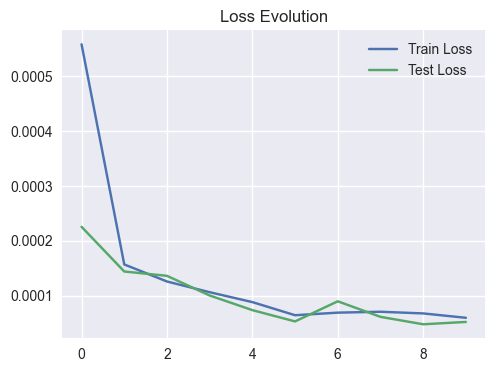

In [5]:
# construct model
training_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(len(prices))    # output layer with the same number of columns as the input
])

# compile the model
training_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.002), loss='mean_squared_error')

# train the model
history = training_model.fit(X_train, y_train, epochs=10, batch_size=16, validation_data=(X_test, y_test))

# plot the training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.legend()
plt.title('Loss Evolution')

In [6]:
class InferenceModel(tf.keras.Model):
    def __init__(self, training_model, latest_sequence_per_token, min_price: float, max_price: float):
        super(InferenceModel, self).__init__()
        self.training_model = training_model
        self.min_price = min_price
        self.max_price = max_price
        self.latest_sequence_per_token = tf.constant(latest_sequence_per_token, dtype=tf.float32)  # convert to tensor

    @tf.function
    def call(self, inputs):
        num_intervals = inputs[0]
        num_intervals = tf.cast(num_intervals, dtype=tf.int32)  # convert to int32
        token = inputs[1]
        token = tf.cast(token, dtype=tf.int32)  # convert to int32
        price = inputs[2]
        price = tf.cast(price, dtype=tf.int32)
        sequence = tf.gather(self.latest_sequence_per_token, token)    # get the latest sequence for the token
        len_sequence = tf.constant(sequence.shape[0], dtype=tf.int32)  # get the length of the sequence

        # Define the loop condition
        def condition(i, sequence):
            return i < num_intervals

        # Define the loop body
        def body(i, sequence):
            inputs = sequence[-len_sequence:, :]        # get the last sequence
            inputs = tf.expand_dims(inputs, axis=0)     # add the batch dimension
            prediction = self.training_model(inputs)    # predict the closing price for the next interval
            sequence = tf.concat([sequence, prediction], axis=0)            # append the prediction to the sequence
            return i + 1, sequence

        # Use tf.while_loop to construct the loop
        _, final_sequence = tf.while_loop(condition, body, [0, sequence], shape_invariants=[tf.TensorShape([]), tf.TensorShape([None, sequence.shape[1]])])

        # denormalize the result
        final_sequence = final_sequence * (self.max_price - self.min_price) + self.min_price

        return final_sequence[-num_intervals:, price]  # return the last value in the sequence
    

# create a dictionary with the latest sequence for each token
latest_sequence_per_token = [data[data['token'] == token][prices].values[-len_sequence:] for token in data['token'].unique()]
tokens = {element:idx for idx, element in enumerate(data['token'].unique())}
print("Tokens: ", tokens)

# construct and save the inference model
inference_model = InferenceModel(training_model, latest_sequence_per_token, min_price, max_price)
inference_model.build(input_shape=(3,))

Tokens:  {'WBTC': 0, 'WETH': 1, 'USDC': 2, 'USDT': 3, 'DAI': 4, 'LINK': 5, 'AAVE': 6, 'STETH': 7, 'WSTETH': 8, 'ETH': 9, 'FRAX': 10, 'RETH': 11, 'YFI': 12, 'MIM': 13, '3CRV': 14, 'ALCX': 15, 'MKR': 16, 'STMATIC': 17, 'WAVAX': 18, 'UNI': 19, 'COMP': 20, 'GNO': 21, 'COW': 22, 'ALUSD': 23, 'SAVAX': 24, 'WMATIC': 25, 'CVX': 26, 'WOO': 27, 'TUSD': 28, 'FRXETH': 29}


tf.Tensor(
[2536.0488 2567.1807 2603.615  2642.2266 2682.7385 2725.132  2769.457
 2815.7961 2864.2466 2914.9167 2967.9175 3023.366  3081.382  3142.0906
 3205.6208 3272.1108 3341.7043 3414.5544 3490.8228 3570.68   3654.3088
 3741.9014 3833.6626 3929.8118 4030.5781 4136.21   4246.969  4363.1333
 4485.0005 4612.887  4747.132  4888.095  5036.1636 5191.7485 5355.291
 5527.266  5708.178  5898.578 ], shape=(38,), dtype=float32)
Predicted Close price for token 'BTC' on 2024-06-24: 5898.578125


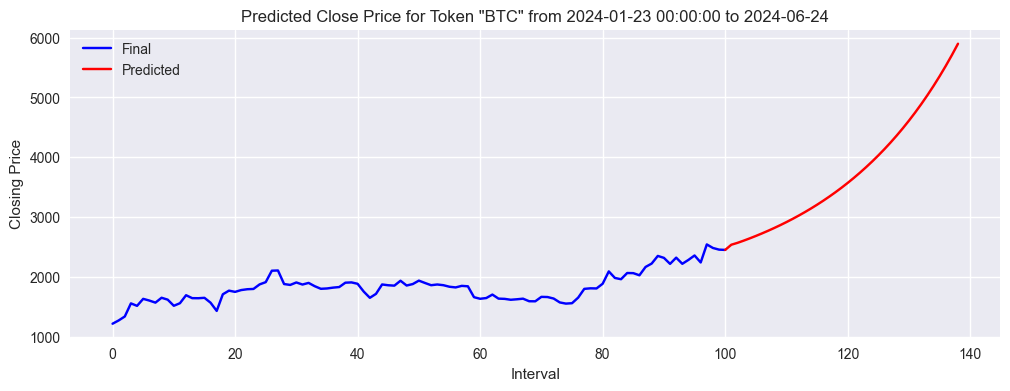

In [7]:
# Run the model to predict the closing price on 2024-02-04 for token 'FRXETH'

# get the number of intervals between the most recent date and the target date (interval = 4 days)
target_date = '2024-06-24'
num_intervals = (pd.Timestamp(target_date) - most_recent_date).days // 4
token = tokens['FRXETH']
price = prices.index('Close')

# predict the closing price for the target date
predicted_sequence = inference_model(inputs=[num_intervals, token, price])
print(predicted_sequence)
print(f"Predicted Close price for token 'BTC' on {target_date}: {predicted_sequence[-1]}")

# append the predicted sequence to the latest sequence in the dataset
final_sequence = latest_sequence_per_token[token][:, price] # shape: (len_sequence,)
final_sequence = final_sequence * (max_price - min_price) + min_price   # unnormalize the sequence
final_sequence = np.concatenate([final_sequence, predicted_sequence.numpy()]) # shape: (len_sequence + num_intervals,)

# plot the final sequence
plt.figure(figsize=(12, 4))
plt.plot(final_sequence[:len_sequence], label='Final', color='blue')

# plot the predicted sequence
plt.plot(range(len_sequence-1, len(final_sequence)), final_sequence[len_sequence-1:], label='Predicted', color='red')

plt.title(f'Predicted Close Price for Token "BTC" from {most_recent_date} to {target_date}')
plt.xlabel('Interval')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

In [8]:
    # Save the model
inference_model.export('TokenPricePredictionModel/0000001')

INFO:tensorflow:Assets written to: TokenPricePredictionModel/0000001\assets


INFO:tensorflow:Assets written to: TokenPricePredictionModel/0000001\assets


Saved artifact at 'TokenPricePredictionModel/0000001'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None,), dtype=tf.float32, name=None)
Output Type:
  TensorSpec(shape=(None,), dtype=tf.float32, name=None)
Captures:
  1993030317184: TensorSpec(shape=(30, 101, 4), dtype=tf.float32, name=None)
  1993025029744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1993025030272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1993025030800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1993025030096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1993025030976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1993025032032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1993025031680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1993025032208: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [9]:
# deploy the model to a TensorFlow Serving container
!docker run -d -p 8501:8501 --name tfserving_token_price_prediction --mount type=bind,source=/c/Users/Moses/Desktop/TokenPricePredictionModel/TokenPricePredictionModel,target=/models/TokenPricePredictionModel -e MODEL_NAME=TokenPricePredictionModel -t tensorflow/serving

12269faaf521f9b021cbce562702705f9895359f723122663aa8676531abbb8a


In [10]:
# make a request to the container to predict the closing price on 2024-02-04 for token 'FRXETH'

# get the number of intervals between the most recent date and the target date (interval = 4 days)
target_date = '2024-02-04'
num_intervals = (pd.Timestamp(target_date) - most_recent_date).days // 4

# make a request to the TensorFlow Serving container
import requests
import json

url = 'http://localhost:8501/v1/models/TokenPricePredictionModel:predict'
headers = {"content-type": "application/json"}
data = json.dumps({"signature_name": "serving_default", "instances": [num_intervals, tokens["FRXETH"], prices.index("Close")]})
response = requests.post(url, data=data, headers=headers)
print(response.json())

{'predictions': [2536.04883, 2567.18066, 2603.61499]}
